# XGBoost model

* Let's start with xgboost, gradient boosting trees usually gives nice results on that kind of problem. The sklearn implementation of gradient boosting trees seems really slow compare to the xgboost one, probably due to the ability of xgboost to approximate the distributions with histograms when splitting.

In [1]:
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

import xgboost
import pandas as pd
from sklearn import utils
from sklearn import metrics
from sklearn import preprocessing
import numpy as np

from xgboost import plot_importance
import matplotlib.pyplot as plt

/usr/local/lib/python2.7/dist-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


* Loading the training set:

In [2]:
data_train = pd.read_csv("data/train.csv")
data_train.drop("id", axis = 1, inplace=True)

In [3]:
data_test = pd.read_csv("data/test.csv")
ids = data_test.values[:, 0]
data_test.drop("id", axis = 1, inplace=True)

* Encoding categorical variables:

In [4]:
whole_categ_data = pd.concat( [ data_train.iloc[:,0:116], data_test.iloc[:,0:116] ], ignore_index=True ).iloc[:, 0:116]

from collections import defaultdict
label_encoder = defaultdict( preprocessing.LabelEncoder )
whole_categ_data = whole_categ_data.apply(lambda x: label_encoder[x.name].fit_transform(x) )

data_train.iloc[:, 0:116] = data_train.iloc[:,0:116].apply(lambda x: label_encoder[x.name].transform(x) )
data_test.iloc[:, 0:116] = data_test.iloc[:,0:116].apply(lambda x: label_encoder[x.name].transform(x) )

* Loading features and target:

In [5]:
X = data_train.values[:, :-1]
y = data_train.values[:, -1]

* Log transform the target, as xgboost cannot minimize MAE since it needs the second order derivative (some MAE approximation that are differentiable twice exist, should try it)

In [6]:
def target_transform(y):
    return np.log(y)

def target_inv_transform(y):
    return np.exp(y)

y = target_transform(y)

* We wont use one hot encoding here since its time consuming and boosted decision trees are not so bad with categorical variables

* Shuffle, even if its automatic during CV, it costs nothing and can avoid mistakes:

In [7]:
X, y = utils.shuffle(X, y)

* Building training xgboost input:

In [8]:
train = xgboost.DMatrix(X, y)

* Definine our evaluation metric:

In [9]:
def mae(y_pred, dtrain):
    y_true = dtrain.get_label()
    return 'mae', metrics.mean_absolute_error( target_inv_transform(y_pred),
                                               target_inv_transform(y_true) )

* Give a try using default parameters:

In [10]:
params = {'objective': 'reg:linear'}

cv_res = xgboost.cv(params = params,
                    dtrain = train,
                    num_boost_round = 1000,
                    nfold = 5,
                    early_stopping_rounds = 20,
                    feval = mae)

print 'Best mae cv score:', cv_res['test-mae-mean'].iloc[-1], '+-', cv_res['test-mae-std'].iloc[-1]

Best mae cv score: 1161.3901124 +- 5.75202082221


* Here we have used early stopping to stop whenever the cross validation score starts increasing:

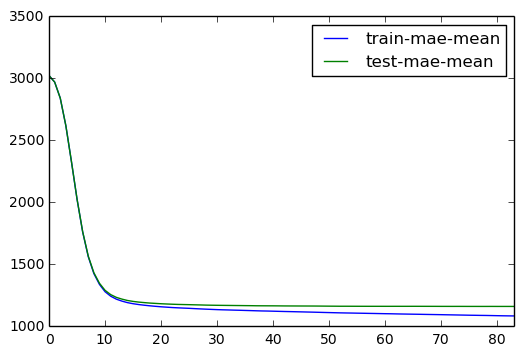

In [11]:
cv_res[['train-mae-mean', 'test-mae-mean']].plot()

* Now we will use hyperopt package to find a better set of hyperparameters:

In [12]:
from hyperopt import hp
from hyperopt import fmin, STATUS_OK, tpe, hp, space_eval
from sklearn.model_selection import cross_val_score
import copy


def convert_params(params):    
    converted = copy.deepcopy(params)
    converted['max_depth'] = int(converted['max_depth'])
    converted['min_child_weight'] = int(converted['min_child_weight'])
    return converted

def score(params):  
    converted = convert_params( params )
    print "Training with params : "
    print converted
    
    cv_res = xgboost.cv(params = converted,
                        dtrain = train,
                        num_boost_round = 1000,
                        nfold = 5,
                        early_stopping_rounds = 20,
                        feval = mae)

    best_cv = cv_res['test-mae-mean'].iloc[-1]
    best_cv_std = cv_res['test-mae-std'].iloc[-1]
    print 'Best mae cv score:', best_cv, '+-', best_cv_std
  
    return {'loss': best_cv, 'status': STATUS_OK}

* The optimization has been done in a terminal since it's not possible to ctrl + z then fg when inside a notebook :(

In [13]:
#Find best
space = {
             'eta' : hp.quniform('eta', 0.025, 0.5, 0.025),
             'max_depth' : hp.quniform('max_depth', 3, 15, 1),
             'min_child_weight' : hp.quniform('min_child_weight', 1, 200, 1),
             'subsample' : hp.quniform('subsample', 0.5, 1, 0.05),
             'colsample_bytree' : hp.quniform('colsample_bytree', 0.5, 1, 0.05),
             'gamma' : hp.quniform('gamma', 0.0, 1.0, 0.05),
             'silent' : 1,
             'base_score' : metrics.mean_squared_error( y, y.mean()*np.ones(y.shape) )
             }

#best = fmin(score, space, algo=tpe.suggest, max_evals=100)
#best = space_eval(space, best)

#Best parameters in our phase space :
best = {'colsample_bytree': 0.55, 'min_child_weight': 186.0, 'subsample': 0.8500000000000001, 'eta': 0.025, 'max_depth': 12.0, 'gamma': 0.8500000000000001}

best = convert_params(best)

* We now have a better set of parameters (we already know the result from the optimisation script but let's put it in the notebook) :

In [14]:
cv_res = xgboost.cv(params = best,
                    dtrain = train,
                    num_boost_round = 1000,
                    nfold = 5,
                    early_stopping_rounds = 20,
                    feval = mae)

print 'MAE cv score:', cv_res['test-mae-mean'].iloc[-1], '+-', cv_res['test-mae-std'].iloc[-1]

MAE cv score: 1135.508423 +- 4.73347793046


* Now we can train on the whole dataset:

In [15]:
%%time
xgb_model = xgboost.train(params = best,
                          dtrain = train,
                          num_boost_round  = 800)

CPU times: user 35min 15s, sys: 2.64 s, total: 35min 18s
Wall time: 9min 31s


* And predict the target on the test set:

In [16]:
X = data_test.values
test = xgboost.DMatrix(X)

pred = target_inv_transform( xgb_model.predict(test) )

submission = pd.DataFrame( {'id': ids, 'loss': pred } )
submission.to_csv('xgboost_predictions.csv', index = False)

* Our MAE score on kaggle (after the end of the competition) is 1130.1 with this model.

* We can also plot features importance: the resulting ranking is not the same as when using more naive approaches such as correlations with the target (as I did in the exploration notebook). The most important variables can be taken to build interaction features and improve the predicting power of our model.

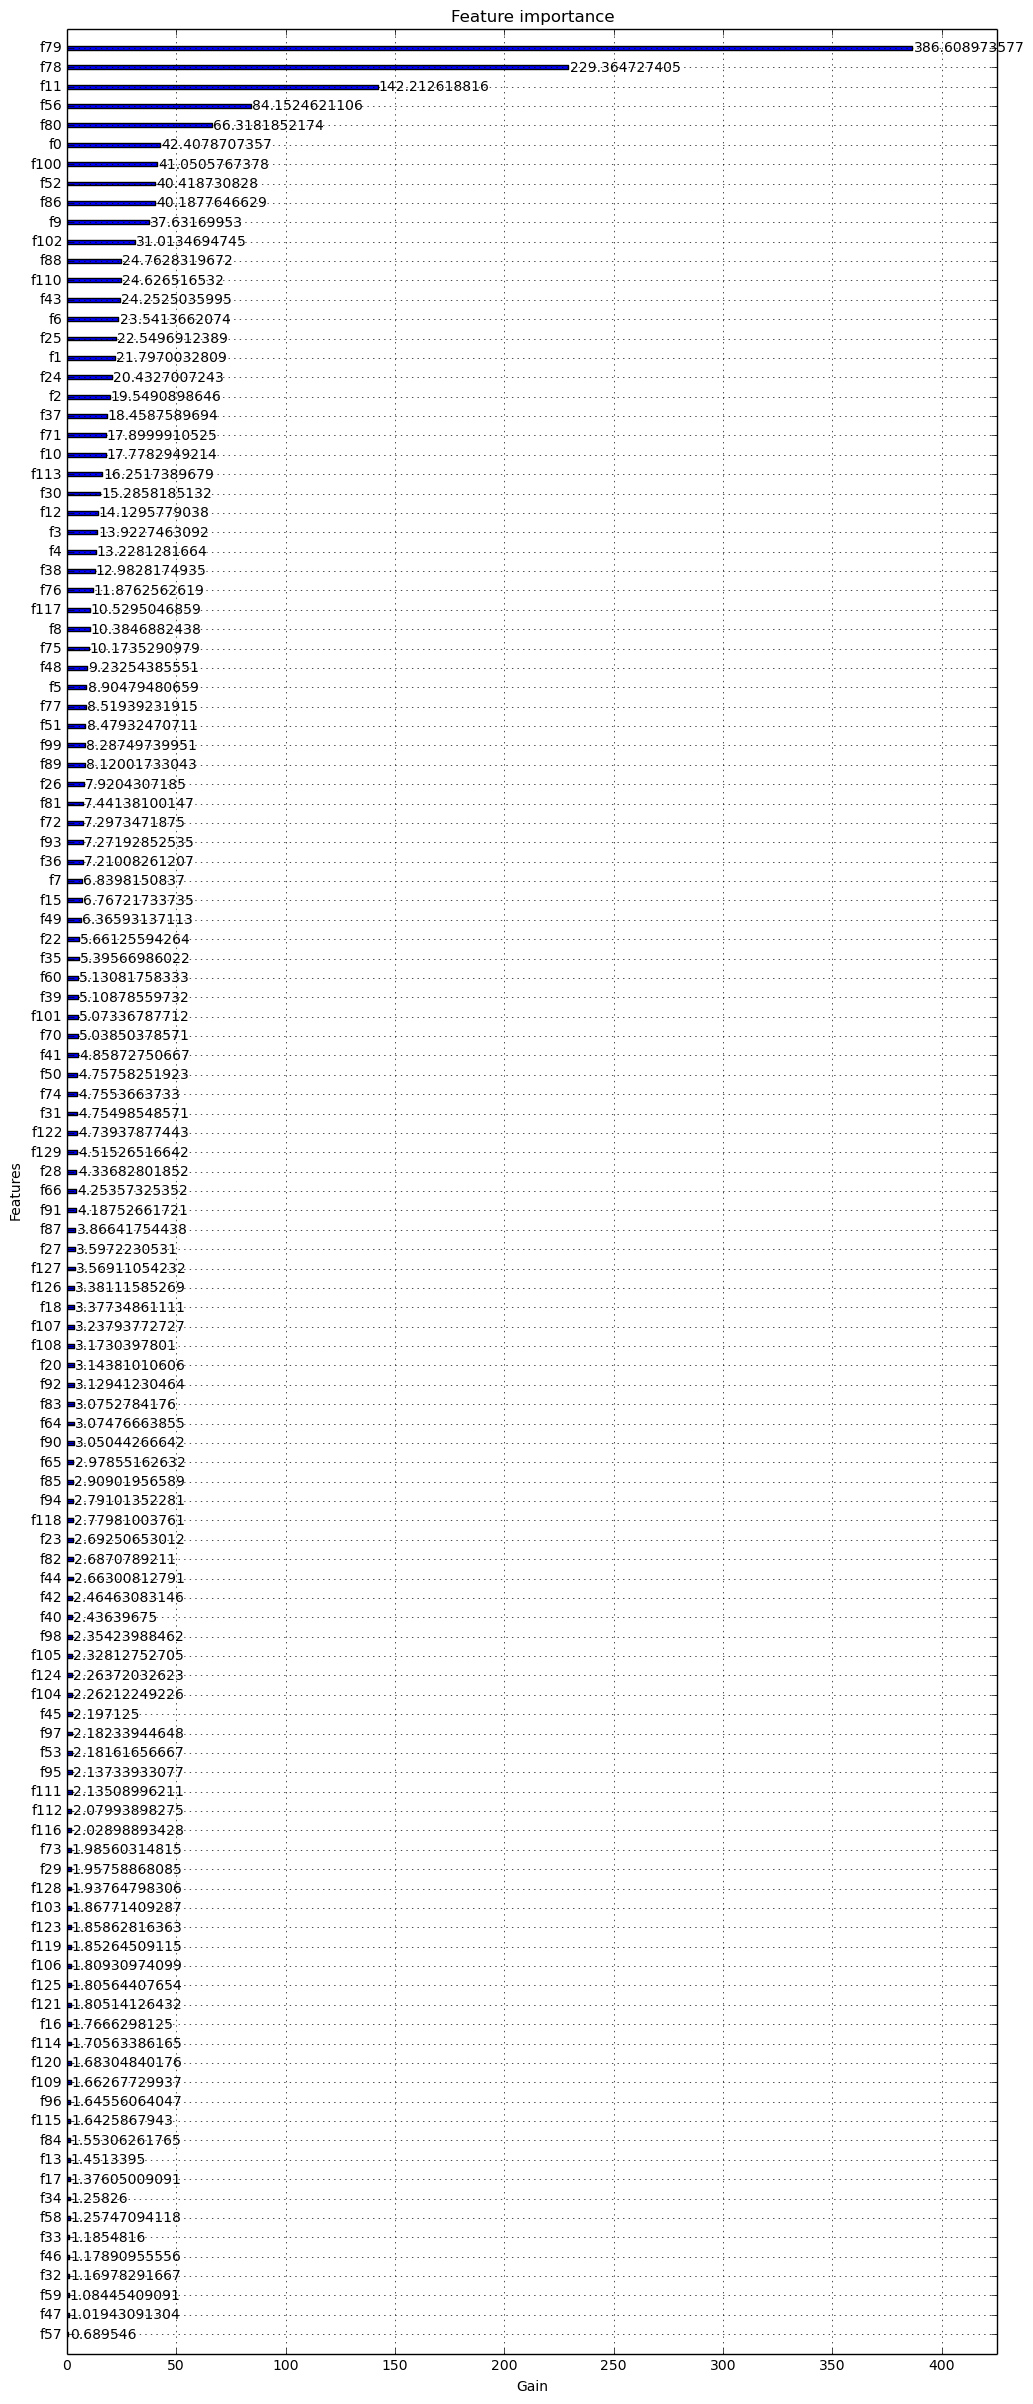

In [17]:
plt.rcParams['figure.figsize'] = (12, 30)
xgboost.plot_importance(xgb_model, importance_type = "gain", xlabel='Gain')